We use the same dataset used in GraphWriter
https://github.com/rikdz/GraphWriter

<h1> Installs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !cp '/content/gdrive/My Drive/TRAINING_SET_binary.zip' TRAINING_SET_binary.zip
# !unzip TRAINING_SET_binary.zip

Mounted at /content/gdrive
Archive:  TRAINING_SET_binary.zip
  inflating: TRAINING_SET_binary     


In [ ]:
!git clone https://github.com/haitzsaezdeocariz/kg_data.git

Cloning into 'kg_data'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [ ]:
!unzip kg_data/preprocessed_data.zip

Archive:  kg_data/preprocessed_data.zip
  inflating: preprocessed.test.tsv   
  inflating: preprocessed.train.tsv  
  inflating: preprocessed.val.tsv    


Note: for some reason we need to downgrade pytorch, otherwise colab will collapse (May 2022)

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

<h1> Dataset: Description and Importing

AGENDA DATASET
1. Text Graph Pairings
2. 40k SAMPLES approx
3. Graphs are small

You can process your data to a tab-separated list with the following fields:

title, entities, entity type, graph, target, ordering

1. "title" paper title
2. "entities" is a semi-colon delimited list of entities
3. "entity type" is a space delimited list of one type token associated with each entity
4. "graph" is a semi-colon delimited list of graph triples, where the head and tail are indexes of the entities in the "entities" list and the relation is the index of the relation in the data/relations.vocab file. <head, relation, tail> triples divided by ';'
5. "target" is your target text with entities replaced by placeholders indicating the entity type and its index in the "entities" list
6. "ordering" is not used, but you may need to put a placeholder there to get the code to work as is. Alternately, you can modify the code to ignore this field

Define relations 'relations' for different graph links

In [ ]:
import csv
tsv_file = open("preprocessed.train.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")

title, entities, entity_type, graph, target, ordering = [],[],[],[],[],[]
for row in read_tsv:
  title.append(row[0])
  entities.append(row[1])
  entity_type.append(row[2])
  graph.append(row[3])
  target.append(row[4])
  ordering.append(row[5])

<h1> View data <h1>

In this cells we visualize the different columns of the tsv file for a given sample

In [ ]:
title[0]

'Constrained minimization technique for topic identification using discriminative training and support vector machines .'

In [ ]:
entities[0]

'latent semantic indexing matrix ; discrimina-tive training ; constrained minimization approach ; support vector machines ; banking call routing ; combination strategy ; classification error ; classification accuracy ; classifier accuracy ; switchboard databases ; vector-space model ; lsi matrix ; baseline classifiers ; score separation ; classifiers ; ensemble ; classifier ; accuracy'

In [ ]:
entity_type[0]

'<method> <method> <method> <method> <task> <method> <task> <metric> <metric> <material> <method> <method> <method> <metric> <method> <method> <method> <metric>'

In [ ]:
graph[0]

'17 5 16 ; 1 0 11 ; 2 0 11 ; 2 0 7 ; 1 0 6 ; 16 4 12 ; 17 5 12 ; 3 1 0 ; 14 1 2'

In [ ]:
target[0]

'this paper describes the <method_2> to combine multiple <method_14> in order to improve <metric_7> . since errors of individual <method_14> in the <method_15> should somehow be uncorrelated to yield higher <metric_7> , we propose a <method_5> where the combined <metric_8> is a function of the correlation between classification errors of the individual <method_14> . to obtain powerful single <method_14> , different techniques are investigated including <method_3> and <method_0> , which is a popular <method_10> . we also investigate <method_1> of the <method_11> on <method_2> . <method_1> minimizes the <task_6> by increasing the <metric_13> of the correct from competing documents . experimental evaluation is carried out on a <task_4> and on <material_9> with a set of 23 and 67 topics respectively . results show that the combined <method_16> we propose outperforms the <metric_17> of individual <method_12> by 44 % .'

In [ ]:
ordering[0]

'2 14 7 22 27 18 -1 15 5 8 18 -1 3 0 10 26 18 -1 1 11 20 21 18 -1 6 13 23 18 -1 18 -1 4 9 19 24 25 18 -1'

<h1> Recover abstract from target (We predict the KG based on the abstract and the node entities)

Recover the abstract based on the different columns in the tsv file

In [ ]:
import re

In [ ]:
abstract=[]
for row in range(38720):
  split_text = re.split('<|>',target[row])
  abstract_temporal=''
  for i in split_text:
    if i[0:6] == 'method':
      try:
        index=int(i[7:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:6] == 'metric':
      try:
        index=int(i[7:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:4] == 'task':
      try:
        index=int(i[5:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:len('otherscientificterm')] == 'otherscientificterm':
      try:
        index=int(i[len('otherscientificterm')+1:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    elif i[0:len('material')] == 'material':
      try:
        index=int(i[len('material')+1:])
        abstract_temporal += re.split(';',entities[row])[index]
      except:
        abstract_temporal += i
    else:
      abstract_temporal += i
  abstract.append(abstract_temporal)

In [ ]:
abstract[0]

'this paper describes the  constrained minimization approach  to combine multiple  classifiers  in order to improve  classification accuracy  . since errors of individual  classifiers  in the  ensemble  should somehow be uncorrelated to yield higher  classification accuracy  , we propose a  combination strategy  where the combined  classifier accuracy  is a function of the correlation between classification errors of the individual  classifiers  . to obtain powerful single  classifiers  , different techniques are investigated including  support vector machines  and latent semantic indexing matrix  , which is a popular  vector-space model  . we also investigate  discrimina-tive training  of the  lsi matrix  on  constrained minimization approach  .  discrimina-tive training  minimizes the  classification error  by increasing the  score separation  of the correct from competing documents . experimental evaluation is carried out on a  banking call routing  and on  switchboard databases  wi

<h1> Vectorize Text

We need to find a way to vectorize the text:
1. The node entities (which may contain multiple words)
2. The abstracts

<h1> Tokenizing with Transformers

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

# We are using "paraphrase-MiniLM-L6-v2" model here, You can find list of model [here][2]
model = SentenceTransformer('allenai-specter')


In [ ]:
embedding=768

<h1> Create Graph Class with all necessary data

Here we create a few helper functions and a Graph class which contains all the information we will later need for training our Knowledge Graph link predictor.

<h1> For binary Problem Pre-processing is slightly different

In [ ]:
import numpy as np
import torch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from gensim.models.doc2vec import Doc2Vec
from scipy.sparse import csr_matrix

def A_to_onehot(A_attr):
  A_onehot = np.zeros((A_attr.shape[0],A_attr.shape[1],2))
  for i in range(A_attr.shape[0]):
    for j in range(A_attr.shape[1]):
      if int(A_attr[i,j])==0:
        A_onehot[i,j,0]=1
      else:
        A_onehot[i,j,1]=1
  return A_onehot

def get_fully_connected(nodes):
  edge_index,_=from_scipy_sparse_matrix(csr_matrix(np.ones((len(nodes),len(nodes)))))
  return torch.Tensor(edge_index.float()).type(torch.int64).cuda()

def from_scipy_sparse_matrix(A):
    r"""Converts a scipy sparse matrix to edge indices and edge attributes.

    Args:
        A (scipy.sparse): A sparse matrix.
    """
    A = A.tocoo()
    row = torch.from_numpy(A.row).to(torch.long)
    col = torch.from_numpy(A.col).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_weight = torch.from_numpy(A.data)
    return edge_index, edge_weight

def vectorize_nodes(nodes,attach_abstract,vectorized_abstract):
        for i in range(len(nodes)):
          if attach_abstract:
            if i ==0:
              node_vector=model.encode([nodes[i].lower()])
              node_vector= np.concatenate((node_vector,vectorized_abstract),axis=1)
            else:
              node_vector=np.concatenate(
                  (node_vector,
                  
                  np.concatenate((
                  model.encode([nodes[i].lower()]),vectorized_abstract),axis=1)

                  ),axis=0
              )
          else:
            if i ==0:
              node_vector=model.encode([nodes[i].lower()])
            else:
              node_vector=np.concatenate(
                  (node_vector,
                  model.encode([nodes[i].lower()])
                  ),axis=0
              )  
        return node_vector


def flatten_onehot(A_one_hot):
  flattened_vector = A_one_hot[0,0,:][None,:]
  first_pass = True
  for i in range(A_one_hot.shape[0]):
    for j in range(A_one_hot.shape[1]):
      if first_pass==False:
        flattened_vector=torch.cat((flattened_vector,A_one_hot[i,j,:][None,:]),axis=0)
      first_pass = False
  return flattened_vector

class Graph(object):
    def __init__(self,
                 nodes,
                 A_attr,
                 abstract,
                 attach_abstract=True
                 ):
        """ Graph structure 
            for a mini-batch it will store a big (sparse) graph 
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        #Nodes -> List of strings containing each entity
        # self.nodes = nodes
        #Node type -> List of strings based on entity type
        # self.node_type = node_type
        #Adjacency matrix -> numpy matrix
        # self.A = csr_matrix(A)
        #Adjacency matrix with attributes -> numpy matrix
        # self.A_attr = A_attr
        self.A_onehot = flatten_onehot(torch.Tensor(A_to_onehot(A_attr)).cuda())
        # self.A_onehot_no_flatten=torch.Tensor(A_to_onehot(A_attr)).cuda()
        # self.edge_index, self.edge_weight = from_scipy_sparse_matrix(csr_matrix(A_attr))
        #Edge attribute -> list of lists with edge type (relation) and i,j indeces
        # self.edge_attr = edge_attr
        #Abstract corresponding to the graph -> string
        # self.abstract = abstract
        #Original abstract without substituting node entities -> string
        # self.target = target
        #Title -> Paper title (useless) -> string
        # self.title = title

        #Vectorized graph information
        self.vectorized_abstract=model.encode([abstract.lower()])
        # self.relations = ["USED-FOR","CONJUNCTION","FEATURE-OF","PART-OF","COMPARE","EVALUATE-FOR","HYPONYM-OF"]
        #Whether to attach abstract vectorization to node features
        self.attach_abstract = attach_abstract

        #Node features x
        self.x = torch.Tensor(vectorize_nodes(nodes,self.attach_abstract,self.vectorized_abstract)).cuda()
        #Fully connected A matrix for GAT
        self.fully_connected = get_fully_connected(nodes)
        #Retrive number of nodes in the graph
        self.num_nodes = int(self.x.shape[0]) 

    def set_batch(self, batch): #useful for batching
        self.batch = batch   

    def get_triples(self):
        for index in range(len(self.edge_attr)):
          
          print(self.nodes[self.edge_attr[index][1]]+' -> '+self.relations[self.edge_attr[index][0]]+' -> '+self.nodes[self.edge_attr[index][2]])

Uncomment for pre-processing.

We store all the training data in a list of Graphs. One Graph for each data point.

In [ ]:
from inspect import Traceback
from tqdm import tqdm
# TRAINING_SET_binary = []
attach_abstract=True
# for row in tqdm(range(38720)): #training data has 38720 samples
#   matrix_size = len(re.split(';',entities[row]))
#   A_attr = np.zeros((matrix_size,matrix_size))
#   graph_row=re.split(';',graph[row])
#   edge_attr = []
#   for entries in range(len(graph_row)):
#     i = graph_row[entries].split()[0]
#     j = graph_row[entries].split()[-1]
#     A_attr[int(i),int(j)]=int(graph_row[entries].split()[1])+1
#     # First entry is the attribute, other are i and j (edge indexes)
#   TRAINING_SET_binary.append(Graph(
#       nodes = re.split(';',entities[row]),
#       A_attr = A_attr,
#       abstract = abstract[row],
#       attach_abstract=attach_abstract
#   ))

# TRAINING_SET = TRAINING_SET_binary

In [ ]:
# import pickle
 
# # with open('TRAINING_SET_binary', 'wb') as f:
# #   pickle.dump(TRAINING_SET_binary, f)
# with open("TRAINING_SET_binary", "rb") as fp:   # Unpickling
#   TRAINING_SET_binary= pickle.load(fp)

In [ ]:
# TRAINING_SET_binary=TRAINING_SET_binary

In [ ]:
# first = True
# for index in tqdm(range(1124,len(TRAINING_SET_binary))):
#   count = -1
#   for i in range(TRAINING_SET_binary[index].x.shape[0]):
#     count += 1
#     for j in range(TRAINING_SET_binary[index].x.shape[0]):
#       if j!=0:
#         count +=1
#       if first==True:
#         print('once')
#         input_x = torch.cat((TRAINING_SET_binary[index].x[i][None,:],TRAINING_SET_binary[index].x[j][None,:]),-1).cpu()
#         input_y = TRAINING_SET_binary[index].A_onehot[count][None,:].cpu()
#         first=False
#       else:
#         input_x_temp = torch.cat((TRAINING_SET_binary[index].x[i][None,:],TRAINING_SET_binary[index].x[j][None,:]),-1).cpu()
#         input_x= torch.cat((input_x,input_x_temp),0).cpu()
#         input_y_temp = TRAINING_SET_binary[index].A_onehot[count][None,:].cpu()
#         input_y = torch.cat((input_y,input_y_temp),0).cpu()

In [ ]:
# torch.save(input_y,'input_y_until728')

In [ ]:
# first_nolink=True
# first_link=True
# for i in tqdm(range(input_y.shape[0])):
#   if int(input_y[i][0].item())==1:
#     if first_nolink == True:
#       input_x_nolink=input_x[i][None,:]
#       input_y_nolink=input_y[i][None,:]
#       first_nolink=False
#     else:
#       input_x_nolink = torch.cat((input_x_nolink,input_x[i][None,:]),0)
#       input_y_nolink = torch.cat((input_y_nolink,input_y[i][None,:]),0)
#   else:
#     if first_link == True:
#       input_x_link=input_x[i][None,:]
#       input_y_link=input_y[i][None,:]
#       first_link=False
#     else:
#       input_x_link = torch.cat((input_x_link,input_x[i][None,:]),0)
#       input_y_link = torch.cat((input_y_link,input_y[i][None,:]),0)

Some already pre-processed data loading commands

In [ ]:
!cp '/content/gdrive/My Drive/input_x_nolink_until1124' input_x_nolink_until1124
!cp '/content/gdrive/My Drive/input_y_nolink_until1124' input_y_nolink_until1124
!cp '/content/gdrive/My Drive/input_y_link_until1124' input_y_link_until1124
!cp '/content/gdrive/My Drive/input_x_link_until1124' input_x_link_until1124

!cp '/content/gdrive/My Drive/input_x_nolink_until728' input_x_nolink_until728
!cp '/content/gdrive/My Drive/input_y_nolink_until728' input_y_nolink_until728
!cp '/content/gdrive/My Drive/input_y_link_until728' input_y_link_until728
!cp '/content/gdrive/My Drive/input_x_link_until728' input_x_link_until728

input_x_link1 = torch.load('input_x_link_until1124')
input_x_nolink1 = torch.load('input_x_nolink_until1124')
input_y_link1 = torch.load('input_y_link_until1124')
input_y_nolink1 = torch.load('input_y_nolink_until1124')
input_x_link2 = torch.load('input_x_link_until728')
input_x_nolink2 = torch.load('input_x_nolink_until728')
input_y_link2 = torch.load('input_y_link_until728')
input_y_nolink2 = torch.load('input_y_nolink_until728')

input_x_link = torch.cat(
    (input_x_link1,input_x_link2)
)
input_y_link = torch.cat(
    (input_y_link1,input_y_link2)
)
input_x_nolink = torch.cat(
    (input_x_nolink1,input_x_nolink2)
)
input_y_nolink = torch.cat(
    (input_y_nolink1,input_y_nolink2)
)

del input_x_link1
del input_x_nolink1
del input_y_link1
del input_y_nolink1
del input_x_link2
del input_x_nolink2
del input_y_link2
del input_y_nolink2

<h1> Balance the dataset

In [ ]:
multiply = int(np.round(input_x_nolink.shape[0]/input_x_link.shape[0]))
print(multiply)

38


In [ ]:
train_x = torch.cat((input_x_link.repeat(multiply,1),input_x_nolink),0)
train_y = torch.cat((input_y_link.repeat(multiply,1),input_y_nolink),0)

In [ ]:
index_permutation=torch.randperm(train_x.shape[0])

In [ ]:
train_x=train_x[index_permutation]
train_y=train_y[index_permutation]

In [ ]:
#Imports (note that some are unnecessary)
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GraphNorm
from torch_geometric.nn import GATv2Conv, GatedGraphConv, ResGatedGraphConv, TransformerConv, GeneralConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
import torch.nn as nn
pdist = nn.PairwiseDistance(p=2)
from torch.nn import Linear, ELU, BatchNorm1d, Module, Sequential, Softmax, PReLU, Sigmoid
from torch_scatter import scatter
from torch_scatter import scatter_mean
from sklearn.metrics import precision_recall_fscore_support as score
import pandas
import random
import warnings
warnings.filterwarnings("ignore")


In [ ]:
class LINK_YES_NO(torch.nn.Module):
    def __init__(self,heads=1):
        super(LINK_YES_NO, self).__init__()

        self.mlp_link = Sequential(
            Linear(3072,100), BatchNorm1d(100), ELU(),
            Linear(100,10), BatchNorm1d(10), ELU(),
            Linear(10,10), BatchNorm1d(10), ELU(),
            Linear(10,10), BatchNorm1d(10), ELU(),
            Linear(10,10), BatchNorm1d(10), ELU(),
            Linear(10, 2), Sigmoid(),
          )
    def forward(self,x):
        out = self.mlp_link(x)
        return out

In [ ]:
class LINK_YES_NOv2(torch.nn.Module):
    def __init__(self,heads=1):
        super(LINK_YES_NOv2, self).__init__()

        self.mlp_link = Sequential(
            Linear(3072,1000), BatchNorm1d(1000), ELU(),
            Linear(1000,500), BatchNorm1d(500), ELU(),
            Linear(500,500), BatchNorm1d(500), ELU(),
            Linear(500,500), BatchNorm1d(500), ELU(),
            Linear(500,500), BatchNorm1d(500), ELU(),
            Linear(500,100), BatchNorm1d(100), ELU(),
            Linear(100,100), BatchNorm1d(100), ELU(),
            Linear(100, 2), Sigmoid(),
          )
    def forward(self,x):
        out = self.mlp_link(x)
        return out

In [ ]:
class LINK_YES_NOv3(torch.nn.Module):
    def __init__(self,heads=1):
        super(LINK_YES_NOv3, self).__init__()

        self.mlp_link = Sequential(
            Linear(3072,1000), BatchNorm1d(1000), ELU(),
            Linear(1000,1000), BatchNorm1d(1000), ELU(),
            Linear(1000,500), BatchNorm1d(500), ELU(),
            Linear(500,500), BatchNorm1d(500), ELU(),
            Linear(500,500), BatchNorm1d(500), ELU(),
            Linear(500,500), BatchNorm1d(500), ELU(),
            Linear(500,100), BatchNorm1d(100), ELU(),
            Linear(100,100), BatchNorm1d(100), ELU(),
            Linear(100,100), BatchNorm1d(100), ELU(),
            Linear(100, 2), Sigmoid(),
          )
    def forward(self,x):
        out = self.mlp_link(x)
        return out

In [ ]:
def prediction_2_onehot(a):
  return (a == a.max(axis=1)[:,None]).astype(int)

In [ ]:
def print_fscore(start=0,end=275):

  precision, recall, fscore, support = score(
    prediction_2_onehot(
    predictor(
        test_x
    ).cpu().detach().numpy())
    ,
    test_y.cpu().detach().numpy()
    )
  
  data_f = {'RELATION TYPE': ["NO LINK","LINK"], 'F-SCORE': fscore}
  data_p = {'RELATION TYPE': ["NO LINK","LINK"], 'PRECISION': precision}
  data_r = {'RELATION TYPE': ["NO LINK","LINK"], 'RECALL': recall}
  df_f = pandas.DataFrame(data=data_f)
  df_p = pandas.DataFrame(data=data_p)
  df_r = pandas.DataFrame(data=data_r)

  store_fscore.append(fscore)
  store_precision.append(precision)
  store_recall.append(recall)
  print(df_f)
  print(df_p)
  print(df_r)

  print('AVERGA FSCORE: ',np.mean(fscore))

In [ ]:
criterion = torch.nn.CrossEntropyLoss().cuda()

In [ ]:
#Initialize predictor
predictor = LINK_YES_NOv3().cuda()

#Use cuda (note that all other tensors have already been moved to cuda in previous cells)
predictor.cuda()
predictor.train()

LINK_YES_NOv3(
  (mlp_link): Sequential(
    (0): Linear(in_features=3072, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=1000, out_features=500, bias=True)
    (7): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=500, out_features=500, bias=True)
    (10): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=500, out_features=500, bias=True)
    (13): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ELU(alpha=1.0)
    (15): Linear(in_features=500, out_features=500, bias=True)
    

In [ ]:
sum(p.numel() for p in predictor.parameters() if p.requires_grad)

5405102

In [ ]:
store_loss=[]
store_fscore=[]
store_precision=[]
store_recall=[]
#Initialize optimizer
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4) #learning rate is define here
#Define mini batch
mini_batch_size=100
#Define number of epochs
n_epochs=int(1e34)


#Loop over number of epochs
weighting=0.00
for epochs in range(n_epochs):
  #Cumulative loss over the whole training set
  cum_loss = 0
  # Iterate over the whole training set
  for i in range(int(np.round(141875/mini_batch_size))):
    #Create mini batch, randomly select some samples from the list
    #Compute loss based on Graphs in the minibatch
    indices = torch.randperm(len(tr_x))[:mini_batch_size]
    loss = criterion(    
        predictor(
    tr_x[indices] #x features#edge_index (note that graph-wise everything is fully-connected, but when we create a big batch from the different graph in the minibatch this is not the case anymore)
    )
        ,
    tr_y[indices]) #y is the target, it has a list with the A_onehot for each graph in the minibatch
    cum_loss += loss.item() #This is just to keep track of the loss
    loss.backward() #backpropagate
    optimizer.step() #update model parameters
    optimizer.zero_grad()
  if (epochs+1) % 1 ==0: #Print cumulative loss for the whole training set
    print(f'MEAN LOSS FOR EPOCH {epochs+1}:',cum_loss)
    store_loss.append(cum_loss)
  if (epochs+1) % 1==0:
    # print('Test----')
    # print_fscore(start=0,end=1000,test=True)
    # print('Train---')
    print_fscore()
    print('------------------------')
    # torch.save(predictor,'predictor')
    # files.download("predictor")

MEAN LOSS FOR EPOCH 1: 822.198643386364
  RELATION TYPE   F-SCORE
0       NO LINK  0.787004
1          LINK  0.783883
  RELATION TYPE  PRECISION
0       NO LINK   0.767606
1          LINK   0.804511
  RELATION TYPE    RECALL
0       NO LINK  0.807407
1          LINK  0.764286
AVERGA FSCORE:  0.7854431969955437
------------------------
MEAN LOSS FOR EPOCH 2: 688.1953129470348
  RELATION TYPE   F-SCORE
0       NO LINK  0.833948
1          LINK  0.838710
  RELATION TYPE  PRECISION
0       NO LINK   0.795775
1          LINK   0.879699
  RELATION TYPE    RECALL
0       NO LINK  0.875969
1          LINK  0.801370
AVERGA FSCORE:  0.8363290084513748
------------------------
MEAN LOSS FOR EPOCH 3: 635.2500383257866
  RELATION TYPE   F-SCORE
0       NO LINK  0.856089
1          LINK  0.860215
  RELATION TYPE  PRECISION
0       NO LINK   0.816901
1          LINK   0.902256
  RELATION TYPE    RECALL
0       NO LINK  0.899225
1          LINK  0.821918
AVERGA FSCORE:  0.8581518073245249
------------

KeyboardInterrupt: ignored

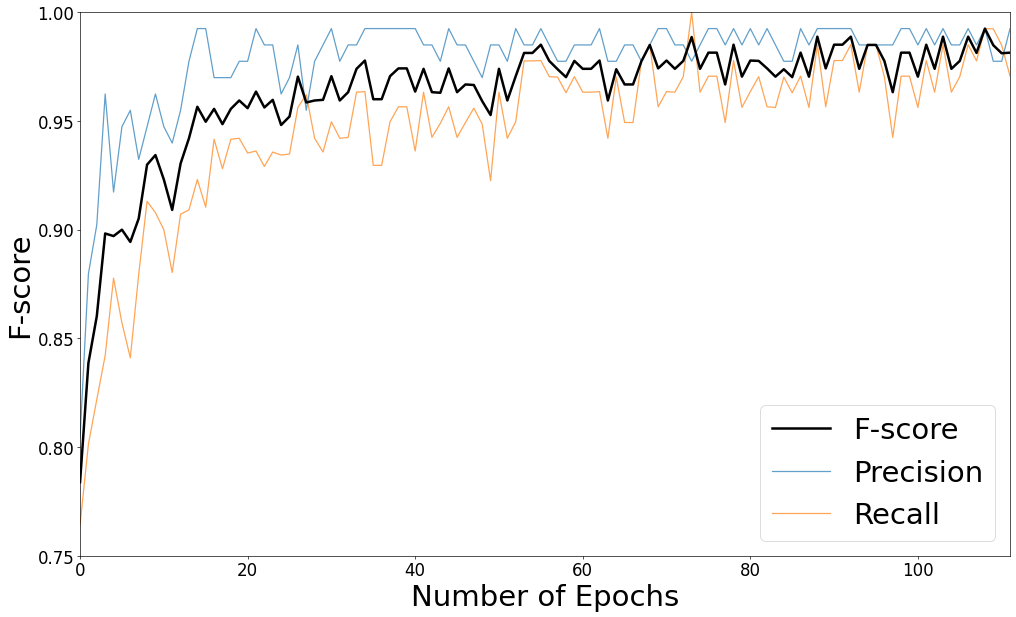

In [ ]:
plt.figure(figsize=(20, 12), dpi=60)
plt.plot(fscore_2,label='F-score',color='black',linewidth=3,zorder=3)
plt.plot(precision_2,label='Precision',alpha=0.7,zorder=1)
plt.plot(recall_2,label='Recall',alpha=0.7,zorder=2)

plt.legend(ncol=1,loc='lower right',fontsize=35)
plt.xlim([0, 111])
plt.ylim([0.75, 1])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Number of Epochs', fontsize=35)
plt.ylabel('F-score', fontsize=35)
plt.savefig('binary_fscore.pdf')